# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [263]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load Data + Use KNN to Impute Missing Values

In [264]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [265]:
# isolate the independent and dependent variables
X_pocket = ANES[['pocketEval']]
X_econ = ANES[['econEval']]
X_ols = ANES[['pocketEval', 'econEval']]
y = ANES['trumpft']

# run the OLS regression for the pocket and econ evaluations
X_ols = sm.add_constant(X_ols)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())

# export the results to a .tex file
with open('outputs/ols_results.tex', 'w') as tf:
    tf.write(model_ols.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     1939.
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:49:17   Log-Likelihood:                -39332.
No. Observations:                7998   AIC:                         7.867e+04
Df Residuals:                    7995   BIC:                         7.869e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.5503      0.426    123.293      0.0

## More Complex OLS Regressions (+ Covariates)

In [266]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# run the OLS regression for the simultaneous pocket and econ evaluations with covariates
regression_cols = ['pocketEval', 'econEval'] + covariates
X_ols_covs = ANES[regression_cols]
X_ols_covs = sm.add_constant(X_ols_covs)
model_ols_covs = sm.OLS(y, X_ols_covs).fit()
print(model_ols_covs.summary())

# export the results to a .tex file
with open('outputs/ols_covs_results.tex', 'w') as tf:
    tf.write(model_ols_covs.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:49:17   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   35.5316 

## Train/Test Split

In [267]:
# define X pocket_cov and X econ_cov
X_pocket_cov = ANES[['pocketEval'] + covariates]
X_econ_cov = ANES[['econEval'] + covariates]

# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train_pocket, y_test_pocket = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train_econ, y_test_econ = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)

# standardize the data
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_pocket_cov_train = scaler.fit_transform(X_pocket_cov_train)
X_pocket_cov_test = scaler.transform(X_pocket_cov_test)
X_econ_cov_train = scaler.fit_transform(X_econ_cov_train)
X_econ_cov_test = scaler.transform(X_econ_cov_test)

X_pocket_cov_train = pd.DataFrame(X_pocket_cov_train, columns=X_pocket_cov.columns)
X_pocket_cov_test = pd.DataFrame(X_pocket_cov_test, columns=X_pocket_cov.columns)
X_econ_cov_train = pd.DataFrame(X_econ_cov_train, columns=X_econ_cov.columns)
X_econ_cov_test = pd.DataFrame(X_econ_cov_test, columns=X_econ_cov.columns)

print(X_pocket_cov_train.head())
print("now econ")
print(X_econ_cov_train.head())
#scaler_y = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_pocket = scaler_y.fit_transform(y_train_pocket.values.reshape(-1, 1))
y_test_pocket = scaler_y.transform(y_test_pocket.values.reshape(-1, 1))
y_train_econ = scaler_y.fit_transform(y_train_econ.values.reshape(-1, 1))
y_test_econ = scaler_y.transform(y_test_econ.values.reshape(-1, 1))

y_train_pocket = pd.DataFrame(y_train_pocket, columns=['trumpft'])
y_test_pocket = pd.DataFrame(y_test_pocket, columns=['trumpft'])
y_train_econ = pd.DataFrame(y_train_econ, columns=['trumpft'])
y_test_econ = pd.DataFrame(y_test_econ, columns=['trumpft'])
#'''


   pocketEval  mode  prepost   sp_serv  sp_serv_biden  sp_serv_trump  \
0         1.0   1.0      1.0  0.066667       1.000000       0.000000   
1        -1.0   1.0     -1.0  0.600000       1.000000      -1.000000   
2         0.0   1.0      1.0 -0.333333       1.000000      -0.666667   
3         0.5   1.0      1.0  1.000000      -0.333333      -1.000000   
4         1.0   1.0      1.0  0.333333       0.000000      -0.666667   

   jobs_living  jobs_living_biden  jobs_living_trump  envir_business  ...  \
0     0.000000           0.000000           0.000000       -0.066667  ...   
1     0.666667          -0.333333          -1.000000       -1.000000  ...   
2     0.000000          -1.000000           0.666667        0.333333  ...   
3     0.000000           0.000000           1.000000       -0.333333  ...   
4    -0.666667           0.000000           0.666667       -1.000000  ...   

   immigration  gun_diff  offensive_language  harassment  no_children  \
0    -1.000000       1.0       

## LASSO Regression

In [268]:

# fit LASSO models
lasso_pocket = Lasso(alpha=0.05, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train_pocket)

lasso_econ = Lasso(alpha=0.05, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train_econ)

# predict the test set
y_pred_pocket = lasso_pocket.predict(X_pocket_cov_test)
y_pred_econ = lasso_econ.predict(X_econ_cov_test)

# print the intercept, number of nonzero coefficients, and the names of nonzero coefficients
print('Lasso Pocket Model:')
print('Intercept:', lasso_pocket.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_pocket.coef_))
print('Nonzero Coefficients:', X_pocket_cov.columns[lasso_pocket.coef_ != 0].tolist())
print('Accuracy:', r2_score(y_test_pocket, y_pred_pocket))

print('\nLasso Econ Model:')
print('Intercept:', lasso_econ.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_econ.coef_))
print('Nonzero Coefficients:', X_econ_cov.columns[lasso_econ.coef_ != 0].tolist())
print('Accuracy:', r2_score(y_test_econ, y_pred_econ))




Lasso Pocket Model:
Intercept: [-0.02034677]
Number of Nonzero Coefficients: 8
Nonzero Coefficients: ['envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']
Accuracy: 0.8543858395871623

Lasso Econ Model:
Intercept: [-0.02031254]
Number of Nonzero Coefficients: 9
Nonzero Coefficients: ['econEval', 'envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']
Accuracy: 0.8543833698545613


## Neural Network (?)

In [269]:
# train a neural network on pocketEval model
class ANESDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train_model, y_train_model, X_test_model, y_test_model, input_dim, hidden_dim, output_dim, n_epochs=50):
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.001)

    anes_train = ANESDataset(X_train_model, y_train_model)
    anes_test = ANESDataset(X_test_model, y_test_model)

    train_loader = DataLoader(anes_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=64, shuffle=False)


    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader

anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train_pocket, X_pocket_cov_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.36931475713849066, Test Loss: 0.10082838714122772
Epoch 2, Train Loss: 0.1846372301131487, Test Loss: 0.09139774337410927
Epoch 3, Train Loss: 0.1507649876922369, Test Loss: 0.08667444005608559
Epoch 4, Train Loss: 0.1340383855253458, Test Loss: 0.08729761570692063
Epoch 5, Train Loss: 0.12512631110846997, Test Loss: 0.08406340122222901
Epoch 6, Train Loss: 0.12486113555729389, Test Loss: 0.08379120007157326
Epoch 7, Train Loss: 0.12116345025599003, Test Loss: 0.08360413417220115
Epoch 8, Train Loss: 0.1205768969655037, Test Loss: 0.08421453669667243
Epoch 9, Train Loss: 0.11776169426739216, Test Loss: 0.08281668081879616
Epoch 10, Train Loss: 0.11265158869326114, Test Loss: 0.08009449154138565
Epoch 11, Train Loss: 0.11711917065083981, Test Loss: 0.08489081919193268
Epoch 12, Train Loss: 0.11745453529059886, Test Loss: 0.0829583092033863
Epoch 13, Train Loss: 0.11388258419930936, Test Loss: 0.0871684019267559
Epoch 14, Train Loss: 0.11294226143509149, Test Loss:

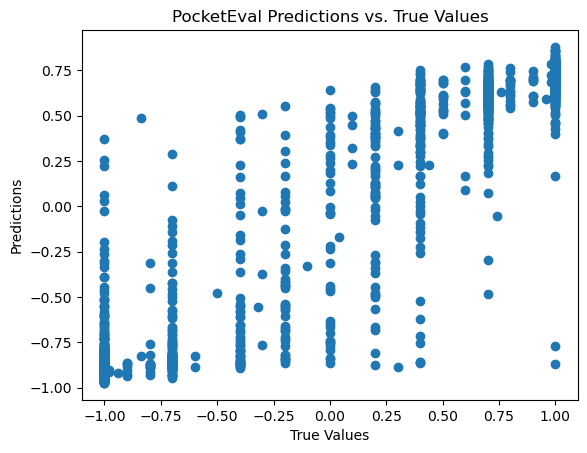

R^2 value for pocketEval model: 0.8728078597401273


In [270]:
anes_net_pocket.eval()
pocket_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        pocket_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_pocket, pocket_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('PocketEval Predictions vs. True Values')
plt.show()
print('R^2 value for pocketEval model:', r2_score(y_test_pocket, pocket_predictions))


In [271]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net_econ, anes_loader = train_model(X_econ_cov_train, y_train_econ, X_econ_cov_test, y_test_econ, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.35652174532413483, Test Loss: 0.10735854893922805
Epoch 2, Train Loss: 0.18882649183273315, Test Loss: 0.08710723653435708
Epoch 3, Train Loss: 0.14936584189534188, Test Loss: 0.08676451712846756
Epoch 4, Train Loss: 0.13569575756788255, Test Loss: 0.0897572822868824
Epoch 5, Train Loss: 0.12750297531485558, Test Loss: 0.08457959845662116
Epoch 6, Train Loss: 0.12406068779528141, Test Loss: 0.08468630865216255
Epoch 7, Train Loss: 0.12178959712386131, Test Loss: 0.0825992453098297
Epoch 8, Train Loss: 0.11260719899088144, Test Loss: 0.08427454516291619
Epoch 9, Train Loss: 0.11660124242305756, Test Loss: 0.08186460211873055
Epoch 10, Train Loss: 0.11539308905601502, Test Loss: 0.08147294566035271
Epoch 11, Train Loss: 0.11450741838663817, Test Loss: 0.08035036265850067
Epoch 12, Train Loss: 0.11123402893543244, Test Loss: 0.0795726202428341
Epoch 13, Train Loss: 0.11244272865355015, Test Loss: 0.08203511446714401
Epoch 14, Train Loss: 0.11034819267690182, Test Lo

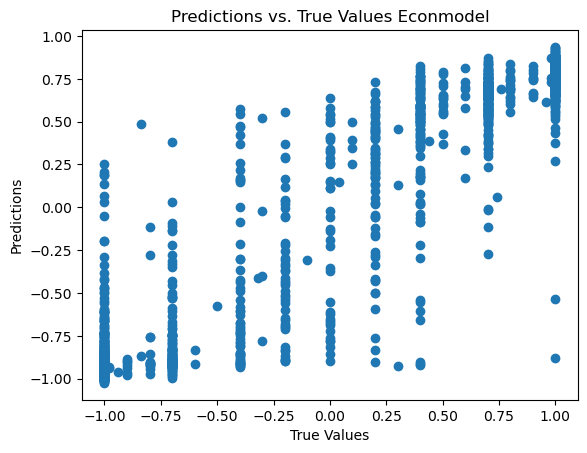

R^2 value for econEval model: 0.8821813125749569


In [ ]:
anes_net_econ.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_econ(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('EconEval Predictions vs. True Values')
plt.show()

print('R^2 value for econEval model:', r2_score(y_test_econ, econ_predictions))

## Random Forest

In [216]:
# run a Random Forest on pocketEval test data and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_pocket = y_train_pocket.values.ravel()
rf_pocket.fit(X_pocket_cov_train, y_train_pocket)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_pocket.head(10)

# get random forest prediction accuracy on pocket test
rf_pocket.score(X_pocket_cov_test, y_test_pocket)
print('Random Forest accuracy on pocketEval model:', rf_pocket.score(X_pocket_cov_test, y_test_pocket))

KeyboardInterrupt: 

In [ ]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_econ = y_train_econ.values.ravel()
rf_econ.fit(X_econ_cov_train, y_train_econ)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)

# get random forest prediction accuracy on econ test
rf_econ.score(X_econ_cov_test, y_test_econ)
print('Random Forest accuracy on econEval model:', rf_econ.score(X_econ_cov_test, y_test_econ))

Random Forest accuracy on econEval model: 0.8853996721513752
